In [1]:
import math
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import datetime as dt

if 'a_api' in sys.modules:
    del sys.modules['a_api']
if 'learn' in sys.modules:
    del sys.modules['learn']
if 'util' in sys.modules:
    del sys.modules['util']

from learn import count_ngrams_plus, count_ngrams_plus_tf_idf
from a_api import TextMetrics

model_family = 'shreevastava_2021_multiclass'
if not os.path.exists('../../data/models/distortions/'+model_family+'/'):
    os.makedirs('../../data/models/distortions/'+model_family+'/')
for split_name in ['first_split','second_split','third_split']:
    split_path = '../../data/models/distortions/'+model_family+'/'+split_name+'/'
    if not os.path.exists(split_path):
        os.makedirs(split_path)

grand_t0 = dt.datetime.now()

def language_metrics(metrics_list, name_split_folder):
    metrics = {}
    for m in metrics_list:
        metrics[m] = f'../../data/models/distortions/{model_family}/{name_split_folder}/{m}.txt'
        #metrics[m] = './data/dict/' + 'en' + '/' + m + '.txt'
    return metrics

# Create Dataset
## Field 2530 (Shreevastava 2021) records

In [2]:
# Dataset: Multiple Distorions (sagarikashreevastava)
# Paper: https://aclanthology.org/2021.clpsych-1.17/
# Data: https://www.kaggle.com/datasets/sagarikashreevastava/cognitive-distortion-detetction-dataset

import kagglehub
multiclass_dataset_path = kagglehub.dataset_download("sagarikashreevastava/cognitive-distortion-detetction-dataset")
multiclass_dataset_file_path = multiclass_dataset_path + "/Annotated_data.csv"

df2 = pd.read_csv(multiclass_dataset_file_path) 
df2 = df2.drop('Id_Number', axis=1) # delete columnb with id 

df3 = df2
df3

,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)
0,"Hello, I have a beautiful,smart,outgoing and a...",The voice are always fimilar (someone she know...,Personalization,NaN
1,Since I was about 16 years old I’ve had these ...,I feel trapped inside my disgusting self and l...,Labeling,Emotional Reasoning
2,So I’ve been dating on and off this guy for a...,NaN,No Distortion,NaN
3,My parents got divorced in 2004. My mother has...,NaN,No Distortion,NaN
4,I don’t really know how to explain the situati...,I refused to go because I didn’t know if it wa...,Fortune-telling,Emotional Reasoning
...,...,...,...,...
2525,I’m a 21 year old female. I spent most of my l...,NaN,No Distortion,NaN
2526,I am 21 female and have not had any friends fo...,Now I am at university my peers around me all ...,Overgeneralization,NaN
2527,From the U.S.: My brother is 19 years old and ...,He claims he’s severely depressed and has outb...,Mental filter,Mind Reading
2528,From the U.S.: I am a 21 year old woman who ha...,NaN,No Distortion,NaN


# Create training functions
### Functions for including key N-grams and creating model files

In [3]:
def ngrams_inclusion(model_ngram, ngram_inclusion_threshold):
    filtered_model_ngram = {}
    for distortion, ngram_dict in model_ngram.items():
        # Find the maximum metric value for the current distortion
        max_value = max(ngram_dict.values()) if ngram_dict else 0
        threshold_value = max_value * (ngram_inclusion_threshold / 100)

        # Filter n-grams that meet or exceed the threshold value
        filtered_model_ngram[distortion] = {
            ngram: metric for ngram, metric in ngram_dict.items() if metric >= threshold_value
        }
    return filtered_model_ngram


def create_model_files(filtered_model_ngram, name_split_folder):
    # Create .txt files for each distortion
    output_dir = f'../../data/models/distortions/{model_family}/{name_split_folder}'
    distortion_file_path = f"{output_dir}/All_distortions.txt"
    distortions_labels = []

    with open(distortion_file_path, "w", encoding="utf-8") as distortion_file:
        for distortion, ngrams in filtered_model_ngram.items():
            distortion_ = distortion.replace(" ", "_")
            file_path = f"{output_dir}/{distortion_}.txt"
            sorted_ngrams = sorted(ngrams.items(), key=lambda x: x[1], reverse=True) 
            distortions_labels.append(distortion_)
            with open(file_path, "w", encoding="utf-8") as f:
                for ngram, metric_value in sorted_ngrams:
                    ngram_str = ' '.join(ngram) 
                    f.write(f"{ngram_str}\t{metric_value}\n")
                    if distortion != "No Distortion":
                            distortion_file.write(f"{ngram_str}\t{metric_value}\n")

    old_distortion_file = f"{output_dir}/Distortion.txt"
    if os.path.exists(old_distortion_file):
        os.remove(old_distortion_file)
    os.rename(distortion_file_path, old_distortion_file)
    
    return (list(set(distortions_labels) - {'No_Distortion'}))
    #return (list(set(distortions_labels)))

### Evaluate functions

In [4]:
def f1_from_counts(true_positive, true_negative, false_positive, false_negative):
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    return 2 * precision * recall / (precision + recall) if precision > 0 or recall > 0 else 0 

def evaluate_df_counts(df,evaluator,threshold, tm, debug=False):
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0
    for _, row in df.iterrows():
        # Text definition: first, check the 2nd column; if NaN, take the text from the 1st column.
        text = row.iloc[1] if pd.notna(row.iloc[1]) else row.iloc[0]
        primary_distortion = row.iloc[2]  # The main cognitive distortion from the 3rd column
        secondary_distortion = row.iloc[3] if pd.notna(row.iloc[3]) else None  # The secondary distortion from the 4th column, if it exists
        ground_distortion = False if primary_distortion == 'No Distortion' else True
                       
        our_distortion = evaluator(text,threshold, tm)
        
        # https://en.wikipedia.org/wiki/F-score
        if ground_distortion == True and our_distortion == True:
            true_positive += 1
        if ground_distortion == False and our_distortion == True:
            false_positive += 1
        if ground_distortion == False and our_distortion == False:
            true_negative += 1
        if ground_distortion == True and our_distortion == False:
            false_negative += 1

        if debug:
            print(ground_distortion,our_distortion,text[:20],metrics)

    return true_positive, true_negative, false_positive, false_negative

def evaluate_df(df,evaluator,threshold,tm, debug=False):
    true_positive, true_negative, false_positive, false_negative = evaluate_df_counts(df,evaluator,threshold,tm,debug)
    return f1_from_counts(true_positive, true_negative, false_positive, false_negative)

def evaluate_df_acc_f1(df,evaluator,threshold,tm,debug=False):
    true_positive, true_negative, false_positive, false_negative = evaluate_df_counts(df,evaluator,threshold,tm,debug)
    return (true_positive + true_negative) / len(df), f1_from_counts(true_positive, true_negative, false_positive, false_negative) 

def our_evaluator_any(text,threshold, tm):
    metrics = tm.get_sentiment_words(text)
    for m in metrics:
        if metrics[m] > threshold:
            return True
    return False

def our_evaluator_avg(text,threshold, tm):
    metrics = tm.get_sentiment_words(text)
    l = list(metrics.values())
    avg = sum(l) / len(l) if  len(l) > 0 else 0
    if avg > threshold:
        return True
    return False

### Functions for analyzing the dataset and plot heatmaps

In [5]:
def matrix_plot(row_labels, col_labels, matrix, absmax, title=None, subtitle=None, vmin=None, vmax=None, dpi=None, titlefontsize=None, subtitlefontsize=None, width=20):
    plt.rcParams["figure.figsize"] = (width, len(row_labels) / 4)
    if dpi is not None:
        plt.rcParams["figure.dpi"] = dpi

    fig, ax = plt.subplots()

    p = sns.heatmap(matrix, ax=ax, xticklabels=col_labels, yticklabels=row_labels, 
                    vmin=-absmax if vmin is None else vmin, 
                    vmax=absmax if vmax is None else vmax, 
                    cmap='RdYlGn', annot=True)
    
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    if title is not None:
        if titlefontsize is None:
            titlefontsize = 32 if len(title) < 50 else round(32 * 50 / len(title))
        ax.set_title(title, fontsize=titlefontsize, pad=20)

    if subtitle is not None:
        if subtitlefontsize is None:
            subtitlefontsize = round(titlefontsize * 0.7)
        ax.text(0.5, 1.01, subtitle, fontsize=subtitlefontsize, ha='center', va='bottom', transform=ax.transAxes)

    plt.show()    


def analyse_dataset(ngram_selection_metric, ngram_max, ngram_inclusion_threshold, df_train, df_test, name_split_folder, print_or_plot):
    
    if name_split_folder == 'first_split' and print_or_plot == 'print_results':
        print('\nN-gram selection metric:', ngram_selection_metric)
        print('N-gram max length:', ngram_max)
        print('N-gram inclusion threshold:', ngram_inclusion_threshold)

    if ngram_selection_metric == 'TF-IDF':
        model_ngram = count_ngrams_plus_tf_idf(df_train,ngram_max,binary=False)
    
    elif ngram_selection_metric in ['F','UF','FN','UFN','CFR','FCR','MR','NLMI']:
        distortions, frequency, all_n_grams, frequency_self_normalized, unique_frequency, uniq_all_n_grams, n_gram_distortions, \
        norm_uniq_n_gram_dicts, n_gram_distortions_counts, norm, unique_frequency_self_normalized, norm_norm_uniq, norm_norm_uniq_norm, \
        norm_norm_uniq_norm_norm, fcr, cfr, mr, nl_mi, N = count_ngrams_plus(df_train,ngram_max,binary=False)
        
        selection_metrics = {
            'F':frequency,
            'UF':unique_frequency,
            'FN':frequency_self_normalized,
            'UFN':unique_frequency_self_normalized,
            'CFR':cfr,
            'FCR':fcr,
            'MR':mr,
            'NLMI':nl_mi}
        
        model_ngram = selection_metrics[ngram_selection_metric]

    # Filter out values below the threshold
    filtered_model_ngram = ngrams_inclusion(model_ngram, ngram_inclusion_threshold)

    # Create .txt files for each distortion
    distortions_labels = create_model_files(filtered_model_ngram, name_split_folder)
    tm = TextMetrics(language_metrics(distortions_labels, name_split_folder), encoding = "utf-8", debug=False)

    if print_or_plot == 'print_results':
        if name_split_folder == 'first_split':
            print('\tFIRST COMBINATION')
        elif name_split_folder == 'second_split':
            print('\n\tSECOND COMBINATION')
        elif name_split_folder == 'third_split':
            print('\n\tTHIRD COMBINATION')

    if print_or_plot == 'print_results':
        print('\t\tAny distortion (threshold, accuracy, F1 score):')
    any_res_acc = {}
    any_res = {}
    for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        acc, f1 = evaluate_df_acc_f1(df_test,our_evaluator_any,threshold, tm)
        any_res_acc[threshold] = acc
        any_res[threshold] = f1
        if print_or_plot == 'print_results':
            print('\t\t', threshold, acc, f1)

    avg_res_acc = {}
    avg_res = {}
    if print_or_plot == 'print_results':
        print('\n\t\tAverage distortion (threshold, accuracy, F1 score):')
    for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        acc, f1 = evaluate_df_acc_f1(df_test,our_evaluator_avg,threshold, tm)
        avg_res_acc[threshold] = acc
        avg_res[threshold] = f1
        if print_or_plot == 'print_results':
            print('\t\t', threshold, acc, f1)

    return any_res_acc, avg_res_acc


# Grid search
### Perform a grid search over all hyper-parameters to determine the best combination for building the model

In [6]:
print('Full set',len(df3))
df_test = df3[df3.index % 10 == 0]
print('Test set',len(df_test))
df_tv = df3[df3.index % 10 != 0]
print('Train and valid',len(df_tv))
df_valid = df_tv[df_tv.index % 10 == 1]
print('Valid set',len(df_valid))
df_train = df_tv[(df_tv.index % 10 != 0) & (df_tv.index % 10 != 1)]
print('Train set',len(df_train))

splits = [
        (df_train, df_valid)
        #(pd.concat([part1, part2]), part3),  # (1 + 2) -> train, (3) -> test
        #(pd.concat([part1, part3]), part2),  # (1 + 3) -> train, (2) -> test
        #(pd.concat([part2, part3]), part1)   # (2 + 3) -> train, (1) -> test
]

Full set 2530
Test set 253
Train and valid 2277
Valid set 253
Train set 2024


In [7]:
def grid_search(splits):
    best_param_any = None
    best_acc_any = 0
    best_param_avg = None
    best_acc_avg = 0
    for ngram_selection_metric in ['TF-IDF','F','UF','FN','UFN','CFR','FCR','MR','NLMI']:
        for ngram_max in range (1, 5):
            for ngram_inclusion_threshold in [90, 80, 70, 60, 50, 40, 30, 20, 10, 0]:
                all_values_any = []
                all_values_avg = []
                for i, (train_df, test_df) in enumerate(splits, start=1):
                    if i == 1:
                        first_split_acc_any, first_split_acc_avg = analyse_dataset(ngram_selection_metric, ngram_max, ngram_inclusion_threshold, train_df, test_df, 'first_split', 'print_results')
                        all_values_any += list(first_split_acc_any.values())
                        all_values_avg += list(first_split_acc_avg.values())                        
                    elif i == 2:
                        second_split_acc_any, second_split_acc_avg = analyse_dataset(ngram_selection_metric, ngram_max, ngram_inclusion_threshold, train_df, test_df, 'second_split', 'print_results')
                        all_values_any += list(second_split_acc_any.values())
                        all_values_avg += list(second_split_acc_avg.values())                        
                    elif i == 3:
                        third_split_acc_any, third_split_acc_avg = analyse_dataset(ngram_selection_metric, ngram_max, ngram_inclusion_threshold, train_df, test_df, 'third_split', 'print_results')
                        all_values_any += list(third_split_acc_any.values())
                        all_values_avg += list(third_split_acc_avg.values())                        
                                
                min_value = round(min(all_values_any),3)
                max_value = round(max(all_values_any),3)
                mean_value = round(np.mean(all_values_any),3)

                if best_acc_any < max_value:
                    best_acc_any = max_value
                    best_param_any = (ngram_selection_metric, ngram_max, ngram_inclusion_threshold)

                print(f"\t(Any distortion) Min acc: {min_value}\tMax acc: {max_value}\tMean acc: {mean_value}\tBest acc: {best_acc_any}\tHyper-parameters: {str(best_param_any)}")

                min_value = round(min(all_values_avg),3)
                max_value = round(max(all_values_avg),3)
                mean_value = round(np.mean(all_values_avg),3)

                if best_acc_avg < max_value:
                    best_acc_avg = max_value
                    best_param_avg = (ngram_selection_metric, ngram_max, ngram_inclusion_threshold)

                print(f"\t(Avg distortion) Min acc: {min_value}\tMax acc: {max_value}\tMean acc: {mean_value}\tBest acc: {best_acc_avg}\tHyper-parameters: {str(best_param_avg)}")

    print(f"(Any distortion)Best mean accuracy: {best_acc_any}\tHyper-parameters: {str(best_param_any)}")
    print(f"(Average distortion)Best mean accuracy: {best_acc_avg}\tHyper-parameters: {str(best_param_avg)}")
    return best_param_any, best_param_avg

In [8]:
best_param_any, best_param_avg = grid_search(splits)


N-gram selection metric: TF-IDF
N-gram max length: 1
N-gram inclusion threshold: 90
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.3557312252964427 0.18905472636815923
		 0.2 0.3794466403162055 0.10285714285714284
		 0.3 0.37549407114624506 0.08139534883720931
		 0.4 0.3557312252964427 0.02395209580838323
		 0.5 0.35177865612648224 0.012048192771084336
		 0.6 0.35177865612648224 0.012048192771084336
		 0.7 0.35177865612648224 0.012048192771084336
		 0.8 0.34782608695652173 0
		 0.9 0.34782608695652173 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.35968379446640314 0.19
		 0.2 0.3794466403162055 0.10285714285714284
		 0.3 0.37549407114624506 0.08139534883720931
		 0.4 0.3557312252964427 0.02395209580838323
		 0.5 0.35177865612648224 0.012048192771084336
		 0.6 0.35177865612648224 0.012048192771084336
		 0.7 0.35177865612648224 0.012048192771084336
		 0.8 0.34782608695652173 0
		 0.9 0.34782608695652173 0
	(Any distortion) Min acc: 0.34

		 0.9 0.34782608695652173 0
	(Any distortion) Min acc: 0.348	Max acc: 0.447	Mean acc: 0.371	Best acc: 0.447	Hyper-parameters: ('TF-IDF', 1, 30)
	(Avg distortion) Min acc: 0.348	Max acc: 0.443	Mean acc: 0.37	Best acc: 0.443	Hyper-parameters: ('TF-IDF', 1, 30)

N-gram selection metric: TF-IDF
N-gram max length: 1
N-gram inclusion threshold: 20
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.3952569169960474 0.4742268041237113
		 0.2 0.48221343873517786 0.42794759825327516
		 0.3 0.4308300395256917 0.23404255319148934
		 0.4 0.3715415019762846 0.07017543859649122
		 0.5 0.3557312252964427 0.02395209580838323
		 0.6 0.35177865612648224 0.012048192771084336
		 0.7 0.35177865612648224 0.012048192771084336
		 0.8 0.34782608695652173 0
		 0.9 0.34782608695652173 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.4189723320158103 0.4842105263157894
		 0.2 0.5019762845849802 0.4324324324324324
		 0.3 0.4308300395256917 0.22580645161290322
		 0.4 0.37

		 0.1 0.4031620553359684 0.5623188405797103
		 0.2 0.5019762845849802 0.5935483870967744
		 0.3 0.5731225296442688 0.5645161290322581
		 0.4 0.48616600790513836 0.3627450980392156
		 0.5 0.4031620553359684 0.1564245810055866
		 0.6 0.3675889328063241 0.05882352941176471
		 0.7 0.35968379446640314 0.03571428571428572
		 0.8 0.35177865612648224 0.012048192771084336
		 0.9 0.35177865612648224 0.012048192771084336
	(Any distortion) Min acc: 0.352	Max acc: 0.518	Mean acc: 0.411	Best acc: 0.652	Hyper-parameters: ('TF-IDF', 1, 0)
	(Avg distortion) Min acc: 0.352	Max acc: 0.573	Mean acc: 0.422	Best acc: 0.652	Hyper-parameters: ('TF-IDF', 1, 0)

N-gram selection metric: TF-IDF
N-gram max length: 2
N-gram inclusion threshold: 50
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.40711462450592883 0.5664739884393064
		 0.2 0.45849802371541504 0.5784615384615385
		 0.3 0.525691699604743 0.5620437956204378
		 0.4 0.4901185770750988 0.416289592760181
		 0.5 0.415019762845

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.44664031620553357 0.6022727272727273
		 0.2 0.47035573122529645 0.6058823529411764
		 0.3 0.5849802371541502 0.6440677966101696
		 0.4 0.5928853754940712 0.5761316872427984
		 0.5 0.48221343873517786 0.3482587064676617
		 0.6 0.41106719367588934 0.17679558011049726
		 0.7 0.3675889328063241 0.05882352941176471
		 0.8 0.35968379446640314 0.03571428571428572
		 0.9 0.3557312252964427 0.02395209580838323

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.44664031620553357 0.6022727272727273
		 0.2 0.5335968379446641 0.6358024691358025
		 0.3 0.6126482213438735 0.6449275362318841
		 0.4 0.5810276679841897 0.5350877192982456
		 0.5 0.4743083003952569 0.32487309644670054
		 0.6 0.4031620553359684 0.1564245810055866
		 0.7 0.3675889328063241 0.05882352941176471
		 0.8 0.35968379446640314 0.03571428571428572
		 0.9 0.3557312252964427 0.02395209580838323
	(Any distortion) Min acc: 0.356	Max acc: 0.593	Mea

		 0.5 0.5810276679841897 0.5267857142857143
		 0.6 0.44664031620553357 0.2631578947368421
		 0.7 0.38735177865612647 0.1142857142857143
		 0.8 0.36363636363636365 0.04733727810650888
		 0.9 0.35968379446640314 0.03571428571428572
	(Any distortion) Min acc: 0.364	Max acc: 0.684	Mean acc: 0.526	Best acc: 0.719	Hyper-parameters: ('TF-IDF', 2, 10)
	(Avg distortion) Min acc: 0.36	Max acc: 0.755	Mean acc: 0.529	Best acc: 0.822	Hyper-parameters: ('TF-IDF', 2, 10)

N-gram selection metric: TF-IDF
N-gram max length: 3
N-gram inclusion threshold: 20
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.5968379446640316 0.7475247524752476
		 0.2 0.5968379446640316 0.7475247524752476
		 0.3 0.6047430830039525 0.7512437810945274
		 0.4 0.6324110671936759 0.7571801566579635
		 0.5 0.7233201581027668 0.7756410256410257
		 0.6 0.5889328063241107 0.5517241379310346
		 0.7 0.48616600790513836 0.35
		 0.8 0.391304347826087 0.125
		 0.9 0.3675889328063241 0.05882352941176471

		Av

		 0.3 0.5691699604743083 0.6997245179063362
		 0.4 0.6324110671936759 0.7120743034055728
		 0.5 0.5928853754940712 0.5896414342629482
		 0.6 0.4901185770750988 0.37681159420289856
		 0.7 0.4150197628458498 0.18681318681318682
		 0.8 0.3675889328063241 0.05882352941176471
		 0.9 0.35968379446640314 0.03571428571428572

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.5098814229249012 0.671957671957672
		 0.2 0.549407114624506 0.6902173913043479
		 0.3 0.6561264822134387 0.7387387387387387
		 0.4 0.6877470355731226 0.7106227106227107
		 0.5 0.5652173913043478 0.5
		 0.6 0.4505928853754941 0.27225130890052357
		 0.7 0.38735177865612647 0.1142857142857143
		 0.8 0.36363636363636365 0.04733727810650888
		 0.9 0.35968379446640314 0.03571428571428572
	(Any distortion) Min acc: 0.36	Max acc: 0.632	Mean acc: 0.495	Best acc: 0.751	Hyper-parameters: ('TF-IDF', 3, 10)
	(Avg distortion) Min acc: 0.36	Max acc: 0.688	Mean acc: 0.503	Best acc: 0.822	Hyper-parameters: ('TF-IDF', 2, 10)



		 0.9 0.383399209486166 0.10344827586206896
	(Any distortion) Min acc: 0.652	Max acc: 0.668	Mean acc: 0.654	Best acc: 0.751	Hyper-parameters: ('TF-IDF', 3, 10)
	(Avg distortion) Min acc: 0.383	Max acc: 0.652	Mean acc: 0.61	Best acc: 0.822	Hyper-parameters: ('TF-IDF', 2, 10)

N-gram selection metric: F
N-gram max length: 1
N-gram inclusion threshold: 90
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.5810276679841897 0.7225130890052355
		 0.2 0.616600790513834 0.738544474393531
		 0.3 0.6126482213438735 0.7183908045977012
		 0.4 0.6007905138339921 0.6529209621993127
		 0.5 0.5138339920948617 0.4383561643835616
		 0.6 0.38735177865612647 0.1142857142857143
		 0.7 0.35177865612648224 0.012048192771084336
		 0.8 0.34782608695652173 0
		 0.9 0.34782608695652173 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.5810276679841897 0.7225130890052355
		 0.2 0.616600790513834 0.738544474393531
		 0.3 0.6126482213438735 0.7183908045977012
		 0.4 0.600

		 0.9 0.34782608695652173 0
	(Any distortion) Min acc: 0.348	Max acc: 0.668	Mean acc: 0.561	Best acc: 0.751	Hyper-parameters: ('TF-IDF', 3, 10)
	(Avg distortion) Min acc: 0.348	Max acc: 0.652	Mean acc: 0.549	Best acc: 0.822	Hyper-parameters: ('TF-IDF', 2, 10)

N-gram selection metric: F
N-gram max length: 1
N-gram inclusion threshold: 20
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6521739130434783 0.7894736842105263
		 0.2 0.6521739130434783 0.7894736842105263
		 0.3 0.6521739130434783 0.7894736842105263
		 0.4 0.6521739130434783 0.7894736842105263
		 0.5 0.6521739130434783 0.7884615384615383
		 0.6 0.616600790513834 0.7568922305764411
		 0.7 0.6047430830039525 0.6240601503759399
		 0.8 0.35177865612648224 0.012048192771084336
		 0.9 0.34782608695652173 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6521739130434783 0.7894736842105263
		 0.2 0.6521739130434783 0.7894736842105263
		 0.3 0.6521739130434783 0.7894736842105263
		 0.4 0.

		 0.6 0.3952569169960474 0.13559322033898305
		 0.7 0.35177865612648224 0.012048192771084336
		 0.8 0.34782608695652173 0
		 0.9 0.34782608695652173 0
	(Any distortion) Min acc: 0.348	Max acc: 0.648	Mean acc: 0.528	Best acc: 0.751	Hyper-parameters: ('TF-IDF', 3, 10)
	(Avg distortion) Min acc: 0.348	Max acc: 0.68	Mean acc: 0.505	Best acc: 0.822	Hyper-parameters: ('TF-IDF', 2, 10)

N-gram selection metric: F
N-gram max length: 2
N-gram inclusion threshold: 50
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6245059288537549 0.7688564476885645
		 0.2 0.6284584980237155 0.7707317073170732
		 0.3 0.6284584980237155 0.7696078431372548
		 0.4 0.6007905138339921 0.7390180878552972
		 0.5 0.6245059288537549 0.7230320699708455
		 0.6 0.5691699604743083 0.5361702127659576
		 0.7 0.37549407114624506 0.08139534883720931
		 0.8 0.34782608695652173 0
		 0.9 0.34782608695652173 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6245059288537549 0.7688564476

		 0.3 0.6126482213438735 0.7183908045977012
		 0.4 0.6007905138339921 0.6529209621993127
		 0.5 0.5138339920948617 0.4383561643835616
		 0.6 0.38735177865612647 0.1142857142857143
		 0.7 0.35177865612648224 0.012048192771084336
		 0.8 0.34782608695652173 0
		 0.9 0.34782608695652173 0
	(Any distortion) Min acc: 0.348	Max acc: 0.617	Mean acc: 0.484	Best acc: 0.751	Hyper-parameters: ('TF-IDF', 3, 10)
	(Avg distortion) Min acc: 0.348	Max acc: 0.617	Mean acc: 0.484	Best acc: 0.822	Hyper-parameters: ('TF-IDF', 2, 10)

N-gram selection metric: F
N-gram max length: 3
N-gram inclusion threshold: 80
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.5810276679841897 0.7225130890052355
		 0.2 0.616600790513834 0.738544474393531
		 0.3 0.6126482213438735 0.7183908045977012
		 0.4 0.6007905138339921 0.6529209621993127
		 0.5 0.5138339920948617 0.4383561643835616
		 0.6 0.38735177865612647 0.1142857142857143
		 0.7 0.35177865612648224 0.012048192771084336
		 0.8 0.347826

		 0.3 0.6521739130434783 0.7894736842105263
		 0.4 0.6561264822134387 0.7913669064748202
		 0.5 0.6363636363636364 0.775609756097561
		 0.6 0.6363636363636364 0.7526881720430108
		 0.7 0.4980237154150198 0.40375586854460094
		 0.8 0.34782608695652173 0
		 0.9 0.34782608695652173 0
	(Any distortion) Min acc: 0.348	Max acc: 0.652	Mean acc: 0.576	Best acc: 0.751	Hyper-parameters: ('TF-IDF', 3, 10)
	(Avg distortion) Min acc: 0.348	Max acc: 0.656	Mean acc: 0.564	Best acc: 0.822	Hyper-parameters: ('TF-IDF', 2, 10)

N-gram selection metric: F
N-gram max length: 3
N-gram inclusion threshold: 10
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6521739130434783 0.7894736842105263
		 0.2 0.6521739130434783 0.7894736842105263
		 0.3 0.6521739130434783 0.7894736842105263
		 0.4 0.6521739130434783 0.7894736842105263
		 0.5 0.6521739130434783 0.7894736842105263
		 0.6 0.6521739130434783 0.7894736842105263
		 0.7 0.6284584980237155 0.7661691542288558
		 0.8 0.533596837944

		 0.9 0.34782608695652173 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6245059288537549 0.7688564476885645
		 0.2 0.6324110671936759 0.7726161369193155
		 0.3 0.6561264822134387 0.7808564231738035
		 0.4 0.6442687747035574 0.7398843930635838
		 0.5 0.5810276679841897 0.5859375
		 0.6 0.4308300395256917 0.22580645161290322
		 0.7 0.35177865612648224 0.012048192771084336
		 0.8 0.34782608695652173 0
		 0.9 0.34782608695652173 0
	(Any distortion) Min acc: 0.348	Max acc: 0.628	Mean acc: 0.527	Best acc: 0.751	Hyper-parameters: ('TF-IDF', 3, 10)
	(Avg distortion) Min acc: 0.348	Max acc: 0.656	Mean acc: 0.513	Best acc: 0.822	Hyper-parameters: ('TF-IDF', 2, 10)

N-gram selection metric: F
N-gram max length: 4
N-gram inclusion threshold: 40
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6442687747035574 0.7836538461538463
		 0.2 0.6482213438735178 0.7855421686746988
		 0.3 0.6442687747035574 0.7826086956521738
		 0.4 0.6086956521739131 0.7543

		 0.6 0.5691699604743083 0.5361702127659576
		 0.7 0.37549407114624506 0.08139534883720931
		 0.8 0.34782608695652173 0
		 0.9 0.34782608695652173 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6245059288537549 0.7688564476885645
		 0.2 0.6324110671936759 0.7726161369193155
		 0.3 0.6640316205533597 0.7858942065491185
		 0.4 0.6363636363636364 0.7309941520467836
		 0.5 0.5652173913043478 0.5599999999999999
		 0.6 0.4308300395256917 0.22580645161290322
		 0.7 0.35177865612648224 0.012048192771084336
		 0.8 0.34782608695652173 0
		 0.9 0.34782608695652173 0
	(Any distortion) Min acc: 0.348	Max acc: 0.628	Mean acc: 0.527	Best acc: 0.751	Hyper-parameters: ('TF-IDF', 3, 10)
	(Avg distortion) Min acc: 0.348	Max acc: 0.664	Mean acc: 0.511	Best acc: 0.822	Hyper-parameters: ('TF-IDF', 2, 10)

N-gram selection metric: UF
N-gram max length: 1
N-gram inclusion threshold: 70
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6324110671936759 0.77481840

		 0.3 0.6521739130434783 0.7894736842105263
		 0.4 0.6521739130434783 0.7894736842105263
		 0.5 0.6521739130434783 0.7894736842105263
		 0.6 0.6521739130434783 0.7894736842105263
		 0.7 0.6521739130434783 0.7894736842105263
		 0.8 0.6245059288537549 0.760705289672544
		 0.9 0.4426877470355731 0.25396825396825395

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6521739130434783 0.7894736842105263
		 0.2 0.6521739130434783 0.7894736842105263
		 0.3 0.6521739130434783 0.7894736842105263
		 0.4 0.6521739130434783 0.7894736842105263
		 0.5 0.6521739130434783 0.7894736842105263
		 0.6 0.6521739130434783 0.7894736842105263
		 0.7 0.6521739130434783 0.7894736842105263
		 0.8 0.6324110671936759 0.7452054794520547
		 0.9 0.4150197628458498 0.18681318681318682
	(Any distortion) Min acc: 0.443	Max acc: 0.652	Mean acc: 0.626	Best acc: 0.751	Hyper-parameters: ('TF-IDF', 3, 10)
	(Avg distortion) Min acc: 0.415	Max acc: 0.652	Mean acc: 0.624	Best acc: 0.822	Hyper-parameters: ('TF-IDF',

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6521739130434783 0.7894736842105263
		 0.2 0.6521739130434783 0.7894736842105263
		 0.3 0.6521739130434783 0.7894736842105263
		 0.4 0.6561264822134387 0.7913669064748202
		 0.5 0.6521739130434783 0.7884615384615383
		 0.6 0.6284584980237155 0.7614213197969543
		 0.7 0.6324110671936759 0.6642599277978339
		 0.8 0.3675889328063241 0.05882352941176471
		 0.9 0.34782608695652173 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6521739130434783 0.7894736842105263
		 0.2 0.6521739130434783 0.7894736842105263
		 0.3 0.6521739130434783 0.7894736842105263
		 0.4 0.6561264822134387 0.7913669064748202
		 0.5 0.6363636363636364 0.775609756097561
		 0.6 0.6363636363636364 0.7604166666666667
		 0.7 0.5454545454545454 0.5106382978723404
		 0.8 0.34782608695652173 0
		 0.9 0.34782608695652173 0
	(Any distortion) Min acc: 0.348	Max acc: 0.656	Mean acc: 0.582	Best acc: 0.751	Hyper-parameters: ('TF-IDF', 3, 10

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6324110671936759 0.7748184019370461
		 0.2 0.6324110671936759 0.7748184019370461
		 0.3 0.6363636363636364 0.7766990291262137
		 0.4 0.616600790513834 0.7593052109181142
		 0.5 0.6047430830039525 0.726775956284153
		 0.6 0.6126482213438735 0.6343283582089552
		 0.7 0.38735177865612647 0.12429378531073447
		 0.8 0.34782608695652173 0
		 0.9 0.34782608695652173 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6324110671936759 0.7748184019370461
		 0.2 0.6363636363636364 0.7766990291262137
		 0.3 0.6403162055335968 0.7785888077858881
		 0.4 0.6086956521739131 0.7455012853470437
		 0.5 0.6007905138339921 0.7002967359050445
		 0.6 0.5454545454545454 0.484304932735426
		 0.7 0.36363636363636365 0.04733727810650888
		 0.8 0.34782608695652173 0
		 0.9 0.34782608695652173 0
	(Any distortion) Min acc: 0.348	Max acc: 0.636	Mean acc: 0.535	Best acc: 0.751	Hyper-parameters: ('TF-IDF', 3, 10)
	(Avg distort

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6521739130434783 0.7894736842105263
		 0.2 0.6521739130434783 0.7894736842105263
		 0.3 0.6521739130434783 0.7894736842105263
		 0.4 0.6521739130434783 0.7894736842105263
		 0.5 0.6521739130434783 0.7894736842105263
		 0.6 0.6521739130434783 0.7894736842105263
		 0.7 0.6521739130434783 0.7894736842105263
		 0.8 0.6521739130434783 0.7894736842105263
		 0.9 0.7351778656126482 0.7886435331230283

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6521739130434783 0.7894736842105263
		 0.2 0.6521739130434783 0.7894736842105263
		 0.3 0.6521739130434783 0.7894736842105263
		 0.4 0.6521739130434783 0.7894736842105263
		 0.5 0.6521739130434783 0.7894736842105263
		 0.6 0.6521739130434783 0.7894736842105263
		 0.7 0.6482213438735178 0.7865707434052758
		 0.8 0.6047430830039525 0.7474747474747474
		 0.9 0.43873517786561267 0.2604166666666667
	(Any distortion) Min acc: 0.652	Max acc: 0.735	Mean acc: 0.661	B

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6521739130434783 0.7894736842105263
		 0.2 0.6521739130434783 0.7894736842105263
		 0.3 0.6521739130434783 0.7894736842105263
		 0.4 0.6521739130434783 0.7894736842105263
		 0.5 0.6521739130434783 0.7894736842105263
		 0.6 0.6442687747035574 0.7815533980582525
		 0.7 0.6758893280632411 0.7747252747252747
		 0.8 0.4426877470355731 0.25396825396825395
		 0.9 0.34782608695652173 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6521739130434783 0.7894736842105263
		 0.2 0.6521739130434783 0.7894736842105263
		 0.3 0.6521739130434783 0.7894736842105263
		 0.4 0.6521739130434783 0.7894736842105263
		 0.5 0.6561264822134387 0.7913669064748202
		 0.6 0.6403162055335968 0.7775061124694377
		 0.7 0.5691699604743083 0.653968253968254
		 0.8 0.36363636363636365 0.04733727810650888
		 0.9 0.34782608695652173 0
	(Any distortion) Min acc: 0.348	Max acc: 0.676	Mean acc: 0.597	Best acc: 0.751	Hyper-parameters

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.38735177865612647 0.35684647302904565
		 0.2 0.4426877470355731 0.27692307692307694
		 0.3 0.39920948616600793 0.14606741573033705
		 0.4 0.3675889328063241 0.05882352941176471
		 0.5 0.3557312252964427 0.02395209580838323
		 0.6 0.35177865612648224 0.012048192771084336
		 0.7 0.35177865612648224 0.012048192771084336
		 0.8 0.34782608695652173 0
		 0.9 0.34782608695652173 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.391304347826087 0.35833333333333334
		 0.2 0.43873517786561267 0.26804123711340205
		 0.3 0.39920948616600793 0.14606741573033705
		 0.4 0.36363636363636365 0.04733727810650888
		 0.5 0.3557312252964427 0.02395209580838323
		 0.6 0.35177865612648224 0.012048192771084336
		 0.7 0.35177865612648224 0.012048192771084336
		 0.8 0.34782608695652173 0
		 0.9 0.34782608695652173 0
	(Any distortion) Min acc: 0.348	Max acc: 0.443	Mean acc: 0.372	Best acc: 0.751	Hyper-parameters: ('TF-I

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.40711462450592883 0.5664739884393064
		 0.2 0.45849802371541504 0.5784615384615385
		 0.3 0.525691699604743 0.5620437956204378
		 0.4 0.4901185770750988 0.416289592760181
		 0.5 0.4150197628458498 0.1956521739130435
		 0.6 0.3675889328063241 0.05882352941176471
		 0.7 0.35968379446640314 0.03571428571428572
		 0.8 0.35177865612648224 0.012048192771084336
		 0.9 0.35177865612648224 0.012048192771084336

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.40711462450592883 0.5664739884393064
		 0.2 0.5059288537549407 0.5980707395498391
		 0.3 0.5810276679841897 0.576
		 0.4 0.49407114624505927 0.3786407766990291
		 0.5 0.40711462450592883 0.16666666666666669
		 0.6 0.3675889328063241 0.05882352941176471
		 0.7 0.35968379446640314 0.03571428571428572
		 0.8 0.35177865612648224 0.012048192771084336
		 0.9 0.35177865612648224 0.012048192771084336
	(Any distortion) Min acc: 0.352	Max acc: 0.526	Mean acc:

		 0.4 0.7628458498023716 0.7887323943661971
		 0.5 0.5573122529644269 0.4862385321100917
		 0.6 0.4268774703557312 0.21621621621621626
		 0.7 0.3715415019762846 0.07017543859649122
		 0.8 0.35968379446640314 0.03571428571428572
		 0.9 0.35177865612648224 0.012048192771084336
	(Any distortion) Min acc: 0.356	Max acc: 0.692	Mean acc: 0.548	Best acc: 0.751	Hyper-parameters: ('TF-IDF', 3, 10)
	(Avg distortion) Min acc: 0.352	Max acc: 0.767	Mean acc: 0.538	Best acc: 0.822	Hyper-parameters: ('TF-IDF', 2, 10)

N-gram selection metric: FN
N-gram max length: 2
N-gram inclusion threshold: 20
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6482213438735178 0.7865707434052758
		 0.2 0.6482213438735178 0.7865707434052758
		 0.3 0.6521739130434783 0.7884615384615383
		 0.4 0.6521739130434783 0.7864077669902912
		 0.5 0.6956521739130435 0.8020565552699228
		 0.6 0.758893280632411 0.7946127946127947
		 0.7 0.5612648221343873 0.5022421524663677
		 0.8 0.39920948616600793 

		 0.4 0.6600790513833992 0.7225806451612902
		 0.5 0.5889328063241107 0.5630252100840336
		 0.6 0.4901185770750988 0.3645320197044335
		 0.7 0.4150197628458498 0.18681318681318682
		 0.8 0.35968379446640314 0.03571428571428572
		 0.9 0.3557312252964427 0.02395209580838323

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.5177865612648221 0.6789473684210526
		 0.2 0.5533596837944664 0.6937669376693766
		 0.3 0.6798418972332015 0.7507692307692306
		 0.4 0.6719367588932806 0.6867924528301887
		 0.5 0.525691699604743 0.42857142857142855
		 0.6 0.44664031620553357 0.2631578947368421
		 0.7 0.383399209486166 0.10344827586206896
		 0.8 0.3557312252964427 0.02395209580838323
		 0.9 0.3557312252964427 0.02395209580838323
	(Any distortion) Min acc: 0.356	Max acc: 0.66	Mean acc: 0.498	Best acc: 0.759	Hyper-parameters: ('FN', 2, 20)
	(Avg distortion) Min acc: 0.356	Max acc: 0.68	Mean acc: 0.499	Best acc: 0.822	Hyper-parameters: ('TF-IDF', 2, 10)

N-gram selection metric: FN
N-gram m

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.5098814229249012 0.671957671957672
		 0.2 0.5217391304347826 0.6773333333333333
		 0.3 0.5691699604743083 0.6997245179063362
		 0.4 0.6363636363636364 0.7160493827160492
		 0.5 0.5928853754940712 0.5896414342629482
		 0.6 0.4901185770750988 0.37681159420289856
		 0.7 0.4150197628458498 0.18681318681318682
		 0.8 0.3675889328063241 0.05882352941176471
		 0.9 0.35968379446640314 0.03571428571428572

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.5098814229249012 0.671957671957672
		 0.2 0.549407114624506 0.6902173913043479
		 0.3 0.6561264822134387 0.7387387387387387
		 0.4 0.6877470355731226 0.7106227106227107
		 0.5 0.5652173913043478 0.5
		 0.6 0.4505928853754941 0.27225130890052357
		 0.7 0.38735177865612647 0.1142857142857143
		 0.8 0.36363636363636365 0.04733727810650888
		 0.9 0.35968379446640314 0.03571428571428572
	(Any distortion) Min acc: 0.36	Max acc: 0.636	Mean acc: 0.496	Best acc: 

		 0.9 0.36363636363636365 0.04733727810650888
	(Any distortion) Min acc: 0.379	Max acc: 0.739	Mean acc: 0.597	Best acc: 0.759	Hyper-parameters: ('FN', 2, 20)
	(Avg distortion) Min acc: 0.364	Max acc: 0.822	Mean acc: 0.574	Best acc: 0.85	Hyper-parameters: ('FN', 3, 20)

N-gram selection metric: FN
N-gram max length: 4
N-gram inclusion threshold: 20
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6521739130434783 0.7894736842105263
		 0.2 0.6521739130434783 0.7894736842105263
		 0.3 0.6521739130434783 0.7894736842105263
		 0.4 0.6561264822134387 0.7913669064748202
		 0.5 0.6679841897233202 0.793103448275862
		 0.6 0.7509881422924901 0.8184438040345821
		 0.7 0.6996047430830039 0.7076923076923078
		 0.8 0.48616600790513836 0.35
		 0.9 0.38735177865612647 0.1142857142857143

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6521739130434783 0.7894736842105263
		 0.2 0.6521739130434783 0.7894736842105263
		 0.3 0.6561264822134387 0.791366906474820

		 0.3 0.391304347826087 0.125
		 0.4 0.35968379446640314 0.03571428571428572
		 0.5 0.35177865612648224 0.012048192771084336
		 0.6 0.35177865612648224 0.012048192771084336
		 0.7 0.35177865612648224 0.012048192771084336
		 0.8 0.34782608695652173 0
		 0.9 0.34782608695652173 0
	(Any distortion) Min acc: 0.348	Max acc: 0.431	Mean acc: 0.369	Best acc: 0.759	Hyper-parameters: ('FN', 2, 20)
	(Avg distortion) Min acc: 0.348	Max acc: 0.427	Mean acc: 0.368	Best acc: 0.85	Hyper-parameters: ('FN', 3, 20)

N-gram selection metric: UFN
N-gram max length: 1
N-gram inclusion threshold: 50
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.41106719367588934 0.4659498207885305
		 0.2 0.48616600790513836 0.41441441441441446
		 0.3 0.4308300395256917 0.22580645161290322
		 0.4 0.3715415019762846 0.07017543859649122
		 0.5 0.35968379446640314 0.03571428571428572
		 0.6 0.35177865612648224 0.012048192771084336
		 0.7 0.35177865612648224 0.012048192771084336
		 0.8 0.347826086

		 0.2 0.5059288537549407 0.5980707395498391
		 0.3 0.5810276679841897 0.576
		 0.4 0.49407114624505927 0.3786407766990291
		 0.5 0.40711462450592883 0.16666666666666669
		 0.6 0.3675889328063241 0.05882352941176471
		 0.7 0.35968379446640314 0.03571428571428572
		 0.8 0.35177865612648224 0.012048192771084336
		 0.9 0.35177865612648224 0.012048192771084336
	(Any distortion) Min acc: 0.352	Max acc: 0.526	Mean acc: 0.414	Best acc: 0.759	Hyper-parameters: ('FN', 2, 20)
	(Avg distortion) Min acc: 0.352	Max acc: 0.581	Mean acc: 0.425	Best acc: 0.901	Hyper-parameters: ('UFN', 1, 10)

N-gram selection metric: UFN
N-gram max length: 2
N-gram inclusion threshold: 80
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.41106719367588934 0.5706051873198846
		 0.2 0.4624505928853755 0.5828220858895706
		 0.3 0.5296442687747036 0.5672727272727273
		 0.4 0.49407114624505927 0.42342342342342343
		 0.5 0.4150197628458498 0.1956521739130435
		 0.6 0.3675889328063241 0.058823529

		 0.2 0.6482213438735178 0.7865707434052758
		 0.3 0.6521739130434783 0.7884615384615383
		 0.4 0.6482213438735178 0.7855421686746988
		 0.5 0.691699604743083 0.8010204081632655
		 0.6 0.758893280632411 0.7946127946127947
		 0.7 0.5612648221343873 0.5066666666666667
		 0.8 0.39920948616600793 0.14606741573033705
		 0.9 0.3675889328063241 0.05882352941176471

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6482213438735178 0.7865707434052758
		 0.2 0.6482213438735178 0.7865707434052758
		 0.3 0.6561264822134387 0.7903614457831325
		 0.4 0.7786561264822134 0.8453038674033149
		 0.5 0.7035573122529645 0.7104247104247104
		 0.6 0.466403162055336 0.3076923076923077
		 0.7 0.37549407114624506 0.08139534883720931
		 0.8 0.36363636363636365 0.04733727810650888
		 0.9 0.34782608695652173 0
	(Any distortion) Min acc: 0.368	Max acc: 0.759	Mean acc: 0.597	Best acc: 0.759	Hyper-parameters: ('FN', 2, 20)
	(Avg distortion) Min acc: 0.348	Max acc: 0.779	Mean acc: 0.554	Best acc: 0.901	

		 0.9 0.3557312252964427 0.02395209580838323
	(Any distortion) Min acc: 0.356	Max acc: 0.664	Mean acc: 0.497	Best acc: 0.759	Hyper-parameters: ('FN', 2, 20)
	(Avg distortion) Min acc: 0.356	Max acc: 0.672	Mean acc: 0.496	Best acc: 0.901	Hyper-parameters: ('UFN', 1, 10)

N-gram selection metric: UFN
N-gram max length: 3
N-gram inclusion threshold: 50
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.5968379446640316 0.7475247524752476
		 0.2 0.5968379446640316 0.7475247524752476
		 0.3 0.6126482213438735 0.7550000000000001
		 0.4 0.6561264822134387 0.7692307692307693
		 0.5 0.691699604743083 0.738255033557047
		 0.6 0.5889328063241107 0.5478260869565218
		 0.7 0.4743083003952569 0.32487309644670054
		 0.8 0.391304347826087 0.125
		 0.9 0.3675889328063241 0.05882352941176471

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.5968379446640316 0.7475247524752476
		 0.2 0.6047430830039525 0.7512437810945274
		 0.3 0.7114624505928854 0.80428954423592

		 0.1 0.5098814229249012 0.671957671957672
		 0.2 0.549407114624506 0.6902173913043479
		 0.3 0.6561264822134387 0.7387387387387387
		 0.4 0.6877470355731226 0.7106227106227107
		 0.5 0.5652173913043478 0.5
		 0.6 0.4505928853754941 0.27225130890052357
		 0.7 0.38735177865612647 0.1142857142857143
		 0.8 0.36363636363636365 0.04733727810650888
		 0.9 0.35968379446640314 0.03571428571428572
	(Any distortion) Min acc: 0.36	Max acc: 0.636	Mean acc: 0.496	Best acc: 0.771	Hyper-parameters: ('UFN', 3, 20)
	(Avg distortion) Min acc: 0.36	Max acc: 0.688	Mean acc: 0.503	Best acc: 0.901	Hyper-parameters: ('UFN', 1, 10)

N-gram selection metric: UFN
N-gram max length: 4
N-gram inclusion threshold: 80
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.5098814229249012 0.671957671957672
		 0.2 0.5217391304347826 0.6773333333333333
		 0.3 0.5652173913043478 0.6978021978021978
		 0.4 0.6363636363636364 0.7160493827160492
		 0.5 0.5968379446640316 0.5952380952380951
		 0.6 

		 0.2 0.6521739130434783 0.7894736842105263
		 0.3 0.6521739130434783 0.7894736842105263
		 0.4 0.6521739130434783 0.7894736842105263
		 0.5 0.6561264822134387 0.787286063569682
		 0.6 0.7747035573122529 0.8357348703170029
		 0.7 0.691699604743083 0.7022900763358778
		 0.8 0.4782608695652174 0.33333333333333337
		 0.9 0.38735177865612647 0.1142857142857143

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6521739130434783 0.7894736842105263
		 0.2 0.6521739130434783 0.7894736842105263
		 0.3 0.6561264822134387 0.7913669064748202
		 0.4 0.7233201581027668 0.8205128205128205
		 0.5 0.8300395256916996 0.8580858085808581
		 0.6 0.5652173913043478 0.5
		 0.7 0.4308300395256917 0.22580645161290322
		 0.8 0.3675889328063241 0.05882352941176471
		 0.9 0.36363636363636365 0.04733727810650888
	(Any distortion) Min acc: 0.387	Max acc: 0.775	Mean acc: 0.622	Best acc: 0.775	Hyper-parameters: ('UFN', 4, 20)
	(Avg distortion) Min acc: 0.364	Max acc: 0.83	Mean acc: 0.582	Best acc: 0.901

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6482213438735178 0.7865707434052758
		 0.2 0.6482213438735178 0.7865707434052758
		 0.3 0.6482213438735178 0.7865707434052758
		 0.4 0.6482213438735178 0.7855421686746988
		 0.5 0.6324110671936759 0.7714987714987713
		 0.6 0.6679841897233202 0.7704918032786885
		 0.7 0.525691699604743 0.44444444444444453
		 0.8 0.35177865612648224 0.012048192771084336
		 0.9 0.34782608695652173 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6482213438735178 0.7865707434052758
		 0.2 0.6482213438735178 0.7865707434052758
		 0.3 0.6521739130434783 0.7884615384615383
		 0.4 0.6403162055335968 0.7785888077858881
		 0.5 0.6363636363636364 0.7664974619289341
		 0.6 0.6363636363636364 0.7106918238993711
		 0.7 0.42292490118577075 0.20652173913043478
		 0.8 0.34782608695652173 0
		 0.9 0.34782608695652173 0
	(Any distortion) Min acc: 0.348	Max acc: 0.668	Mean acc: 0.569	Best acc: 0.775	Hyper-parameters: ('UFN', 4, 

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6245059288537549 0.7688564476885645
		 0.2 0.6284584980237155 0.7707317073170732
		 0.3 0.6284584980237155 0.7696078431372548
		 0.4 0.6007905138339921 0.7390180878552972
		 0.5 0.6245059288537549 0.7230320699708455
		 0.6 0.5691699604743083 0.5361702127659576
		 0.7 0.37549407114624506 0.08139534883720931
		 0.8 0.34782608695652173 0
		 0.9 0.34782608695652173 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6245059288537549 0.7688564476885645
		 0.2 0.6324110671936759 0.7726161369193155
		 0.3 0.6640316205533597 0.7858942065491185
		 0.4 0.6363636363636364 0.7309941520467836
		 0.5 0.5652173913043478 0.5599999999999999
		 0.6 0.4308300395256917 0.22580645161290322
		 0.7 0.35177865612648224 0.012048192771084336
		 0.8 0.34782608695652173 0
		 0.9 0.34782608695652173 0
	(Any distortion) Min acc: 0.348	Max acc: 0.628	Mean acc: 0.527	Best acc: 0.775	Hyper-parameters: ('UFN', 4, 20)
	(Avg disto

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6521739130434783 0.7894736842105263
		 0.2 0.6521739130434783 0.7894736842105263
		 0.3 0.6521739130434783 0.7894736842105263
		 0.4 0.6521739130434783 0.7894736842105263
		 0.5 0.6521739130434783 0.7894736842105263
		 0.6 0.6521739130434783 0.7894736842105263
		 0.7 0.6521739130434783 0.7894736842105263
		 0.8 0.6363636363636364 0.7616580310880828
		 0.9 0.4624505928853755 0.29896907216494845

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6521739130434783 0.7894736842105263
		 0.2 0.6521739130434783 0.7894736842105263
		 0.3 0.6521739130434783 0.7894736842105263
		 0.4 0.6521739130434783 0.7894736842105263
		 0.5 0.6521739130434783 0.7894736842105263
		 0.6 0.6521739130434783 0.7894736842105263
		 0.7 0.6482213438735178 0.7865707434052758
		 0.8 0.6205533596837944 0.7176470588235294
		 0.9 0.3715415019762846 0.07017543859649122
	(Any distortion) Min acc: 0.462	Max acc: 0.652	Mean acc: 0.629	

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6521739130434783 0.7894736842105263
		 0.2 0.6521739130434783 0.7894736842105263
		 0.3 0.6521739130434783 0.7894736842105263
		 0.4 0.6561264822134387 0.7913669064748202
		 0.5 0.6521739130434783 0.7884615384615383
		 0.6 0.6284584980237155 0.7614213197969543
		 0.7 0.6324110671936759 0.6642599277978339
		 0.8 0.3675889328063241 0.05882352941176471
		 0.9 0.34782608695652173 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6521739130434783 0.7894736842105263
		 0.2 0.6521739130434783 0.7894736842105263
		 0.3 0.6521739130434783 0.7894736842105263
		 0.4 0.6561264822134387 0.7913669064748202
		 0.5 0.6363636363636364 0.775609756097561
		 0.6 0.6482213438735178 0.7664041994750657
		 0.7 0.5454545454545454 0.5064377682403434
		 0.8 0.34782608695652173 0
		 0.9 0.34782608695652173 0
	(Any distortion) Min acc: 0.348	Max acc: 0.656	Mean acc: 0.582	Best acc: 0.775	Hyper-parameters: ('UFN', 4, 20)
	

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6324110671936759 0.7748184019370461
		 0.2 0.6324110671936759 0.7748184019370461
		 0.3 0.6363636363636364 0.7766990291262137
		 0.4 0.616600790513834 0.7593052109181142
		 0.5 0.6047430830039525 0.726775956284153
		 0.6 0.6126482213438735 0.6343283582089552
		 0.7 0.38735177865612647 0.12429378531073447
		 0.8 0.34782608695652173 0
		 0.9 0.34782608695652173 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6324110671936759 0.7748184019370461
		 0.2 0.6363636363636364 0.7766990291262137
		 0.3 0.6403162055335968 0.7785888077858881
		 0.4 0.6086956521739131 0.7455012853470437
		 0.5 0.6007905138339921 0.7002967359050445
		 0.6 0.5454545454545454 0.484304932735426
		 0.7 0.36363636363636365 0.04733727810650888
		 0.8 0.34782608695652173 0
		 0.9 0.34782608695652173 0
	(Any distortion) Min acc: 0.348	Max acc: 0.636	Mean acc: 0.535	Best acc: 0.775	Hyper-parameters: ('UFN', 4, 20)
	(Avg distortion

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6521739130434783 0.7894736842105263
		 0.2 0.6521739130434783 0.7894736842105263
		 0.3 0.6521739130434783 0.7894736842105263
		 0.4 0.6521739130434783 0.7894736842105263
		 0.5 0.6521739130434783 0.7894736842105263
		 0.6 0.6521739130434783 0.7894736842105263
		 0.7 0.6521739130434783 0.7894736842105263
		 0.8 0.6561264822134387 0.7913669064748202
		 0.9 0.6679841897233202 0.6934306569343066

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6521739130434783 0.7894736842105263
		 0.2 0.6521739130434783 0.7894736842105263
		 0.3 0.6521739130434783 0.7894736842105263
		 0.4 0.6521739130434783 0.7894736842105263
		 0.5 0.6521739130434783 0.7894736842105263
		 0.6 0.6521739130434783 0.7894736842105263
		 0.7 0.6482213438735178 0.7865707434052758
		 0.8 0.549407114624506 0.6885245901639345
		 0.9 0.383399209486166 0.10344827586206896
	(Any distortion) Min acc: 0.652	Max acc: 0.668	Mean acc: 0.654	Bes

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.4268774703557312 0.5396825396825397
		 0.2 0.5454545454545454 0.5344129554655871
		 0.3 0.48221343873517786 0.3482587064676617
		 0.4 0.391304347826087 0.125
		 0.5 0.35968379446640314 0.03571428571428572
		 0.6 0.35177865612648224 0.012048192771084336
		 0.7 0.35177865612648224 0.012048192771084336
		 0.8 0.34782608695652173 0
		 0.9 0.34782608695652173 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.4426877470355731 0.5466237942122187
		 0.2 0.5612648221343873 0.5316455696202532
		 0.3 0.4782608695652174 0.33333333333333337
		 0.4 0.383399209486166 0.10344827586206896
		 0.5 0.35968379446640314 0.03571428571428572
		 0.6 0.35177865612648224 0.012048192771084336
		 0.7 0.35177865612648224 0.012048192771084336
		 0.8 0.34782608695652173 0
		 0.9 0.34782608695652173 0
	(Any distortion) Min acc: 0.348	Max acc: 0.545	Mean acc: 0.401	Best acc: 0.775	Hyper-parameters: ('UFN', 4, 20)
	(Avg distort

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.3794466403162055 0.5198776758409785
		 0.2 0.45454545454545453 0.5337837837837838
		 0.3 0.5098814229249012 0.48333333333333334
		 0.4 0.45454545454545453 0.29591836734693877
		 0.5 0.4031620553359684 0.1564245810055866
		 0.6 0.3675889328063241 0.05882352941176471
		 0.7 0.35968379446640314 0.03571428571428572
		 0.8 0.35177865612648224 0.012048192771084336
		 0.9 0.35177865612648224 0.012048192771084336

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.383399209486166 0.5214723926380368
		 0.2 0.48616600790513836 0.5422535211267606
		 0.3 0.5296442687747036 0.48484848484848486
		 0.4 0.4505928853754941 0.27979274611398963
		 0.5 0.391304347826087 0.125
		 0.6 0.3675889328063241 0.05882352941176471
		 0.7 0.35968379446640314 0.03571428571428572
		 0.8 0.35177865612648224 0.012048192771084336
		 0.9 0.35177865612648224 0.012048192771084336
	(Any distortion) Min acc: 0.352	Max acc: 0.51	Mean acc:

		 0.5 0.6521739130434783 0.7894736842105263
		 0.6 0.6521739130434783 0.7894736842105263
		 0.7 0.6521739130434783 0.7894736842105263
		 0.8 0.6482213438735178 0.7865707434052758
		 0.9 0.6482213438735178 0.7227414330218068
	(Any distortion) Min acc: 0.636	Max acc: 0.652	Mean acc: 0.65	Best acc: 0.775	Hyper-parameters: ('UFN', 4, 20)
	(Avg distortion) Min acc: 0.648	Max acc: 0.652	Mean acc: 0.651	Best acc: 0.901	Hyper-parameters: ('UFN', 1, 10)

N-gram selection metric: FCR
N-gram max length: 3
N-gram inclusion threshold: 90
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.44664031620553357 0.6022727272727273
		 0.2 0.47035573122529645 0.6058823529411764
		 0.3 0.5849802371541502 0.6440677966101696
		 0.4 0.5928853754940712 0.5761316872427984
		 0.5 0.48221343873517786 0.3482587064676617
		 0.6 0.41106719367588934 0.17679558011049726
		 0.7 0.3675889328063241 0.05882352941176471
		 0.8 0.35968379446640314 0.03571428571428572
		 0.9 0.3557312252964427 0.023

		 0.4 0.6403162055335968 0.7672634271099745
		 0.5 0.691699604743083 0.7607361963190183
		 0.6 0.6205533596837944 0.6
		 0.7 0.49407114624505927 0.3663366336633664
		 0.8 0.39920948616600793 0.14606741573033705
		 0.9 0.3675889328063241 0.05882352941176471

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.616600790513834 0.762836185819071
		 0.2 0.616600790513834 0.762836185819071
		 0.3 0.6798418972332015 0.7928388746803068
		 0.4 0.8142292490118577 0.8469055374592833
		 0.5 0.6245059288537549 0.602510460251046
		 0.6 0.48221343873517786 0.3417085427135678
		 0.7 0.39920948616600793 0.14606741573033705
		 0.8 0.36363636363636365 0.04733727810650888
		 0.9 0.35968379446640314 0.03571428571428572
	(Any distortion) Min acc: 0.368	Max acc: 0.692	Mean acc: 0.563	Best acc: 0.775	Hyper-parameters: ('UFN', 4, 20)
	(Avg distortion) Min acc: 0.36	Max acc: 0.814	Mean acc: 0.551	Best acc: 0.901	Hyper-parameters: ('UFN', 1, 10)

N-gram selection metric: FCR
N-gram max length: 3
N-gr

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.4743083003952569 0.6336088154269973
		 0.2 0.48616600790513836 0.6348314606741572
		 0.3 0.5810276679841897 0.670807453416149
		 0.4 0.6324110671936759 0.6516853932584269
		 0.5 0.5375494071146245 0.47058823529411764
		 0.6 0.4505928853754941 0.27225130890052357
		 0.7 0.383399209486166 0.10344827586206896
		 0.8 0.36363636363636365 0.04733727810650888
		 0.9 0.35968379446640314 0.03571428571428572

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.4743083003952569 0.6336088154269973
		 0.2 0.5454545454545454 0.6627565982404692
		 0.3 0.6442687747035574 0.693877551020408
		 0.4 0.6600790513833992 0.653225806451613
		 0.5 0.4980237154150198 0.3864734299516908
		 0.6 0.43478260869565216 0.23529411764705882
		 0.7 0.383399209486166 0.10344827586206896
		 0.8 0.36363636363636365 0.04733727810650888
		 0.9 0.35968379446640314 0.03571428571428572
	(Any distortion) Min acc: 0.36	Max acc: 0.632	Mean acc:

		 0.7 0.6482213438735178 0.7865707434052758
		 0.8 0.549407114624506 0.6885245901639345
		 0.9 0.383399209486166 0.10344827586206896
	(Any distortion) Min acc: 0.652	Max acc: 0.668	Mean acc: 0.654	Best acc: 0.783	Hyper-parameters: ('FCR', 3, 20)
	(Avg distortion) Min acc: 0.383	Max acc: 0.652	Mean acc: 0.61	Best acc: 0.901	Hyper-parameters: ('UFN', 1, 10)

N-gram selection metric: MR
N-gram max length: 1
N-gram inclusion threshold: 90
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.5810276679841897 0.7225130890052355
		 0.2 0.6126482213438735 0.7365591397849462
		 0.3 0.6126482213438735 0.7183908045977012
		 0.4 0.6007905138339921 0.6529209621993127
		 0.5 0.5138339920948617 0.4383561643835616
		 0.6 0.38735177865612647 0.1142857142857143
		 0.7 0.35177865612648224 0.012048192771084336
		 0.8 0.34782608695652173 0
		 0.9 0.34782608695652173 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.5810276679841897 0.7225130890052355
		 0.2 0.61660

		 0.3 0.6521739130434783 0.7894736842105263
		 0.4 0.6561264822134387 0.7913669064748202
		 0.5 0.6403162055335968 0.7796610169491525
		 0.6 0.6403162055335968 0.7660668380462724
		 0.7 0.6245059288537549 0.6332046332046332
		 0.8 0.35968379446640314 0.03571428571428572
		 0.9 0.34782608695652173 0
	(Any distortion) Min acc: 0.352	Max acc: 0.7	Mean acc: 0.599	Best acc: 0.783	Hyper-parameters: ('FCR', 3, 20)
	(Avg distortion) Min acc: 0.348	Max acc: 0.656	Mean acc: 0.581	Best acc: 0.901	Hyper-parameters: ('UFN', 1, 10)

N-gram selection metric: MR
N-gram max length: 1
N-gram inclusion threshold: 20
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6521739130434783 0.7894736842105263
		 0.2 0.6521739130434783 0.7894736842105263
		 0.3 0.6521739130434783 0.7894736842105263
		 0.4 0.6521739130434783 0.7894736842105263
		 0.5 0.6521739130434783 0.7894736842105263
		 0.6 0.6521739130434783 0.7894736842105263
		 0.7 0.6521739130434783 0.7843137254901961
		 0.8 0.6

		 0.7 0.43873517786561267 0.2526315789473684
		 0.8 0.35968379446640314 0.03571428571428572
		 0.9 0.35177865612648224 0.012048192771084336

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6482213438735178 0.7865707434052758
		 0.2 0.6521739130434783 0.7884615384615383
		 0.3 0.6561264822134387 0.7903614457831325
		 0.4 0.6719367588932806 0.783289817232376
		 0.5 0.6521739130434783 0.7232704402515723
		 0.6 0.4624505928853755 0.30612244897959184
		 0.7 0.35968379446640314 0.03571428571428572
		 0.8 0.3557312252964427 0.02395209580838323
		 0.9 0.35177865612648224 0.012048192771084336
	(Any distortion) Min acc: 0.352	Max acc: 0.664	Mean acc: 0.562	Best acc: 0.783	Hyper-parameters: ('FCR', 3, 20)
	(Avg distortion) Min acc: 0.352	Max acc: 0.672	Mean acc: 0.534	Best acc: 0.901	Hyper-parameters: ('UFN', 1, 10)

N-gram selection metric: MR
N-gram max length: 2
N-gram inclusion threshold: 50
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.64822134

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.5810276679841897 0.7225130890052355
		 0.2 0.6086956521739131 0.7345844504021448
		 0.3 0.6047430830039525 0.7159090909090909
		 0.4 0.6007905138339921 0.6529209621993127
		 0.5 0.5217391304347826 0.4524886877828054
		 0.6 0.391304347826087 0.125
		 0.7 0.3557312252964427 0.02395209580838323
		 0.8 0.34782608695652173 0
		 0.9 0.34782608695652173 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.5810276679841897 0.7225130890052355
		 0.2 0.6205533596837944 0.7405405405405406
		 0.3 0.616600790513834 0.7204610951008645
		 0.4 0.5968379446640316 0.6433566433566433
		 0.5 0.5059288537549407 0.42396313364055305
		 0.6 0.383399209486166 0.10344827586206896
		 0.7 0.3557312252964427 0.02395209580838323
		 0.8 0.34782608695652173 0
		 0.9 0.34782608695652173 0
	(Any distortion) Min acc: 0.348	Max acc: 0.609	Mean acc: 0.484	Best acc: 0.783	Hyper-parameters: ('FCR', 3, 20)
	(Avg distortion) Min acc: 0.

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6521739130434783 0.7894736842105263
		 0.2 0.6521739130434783 0.7894736842105263
		 0.3 0.6521739130434783 0.7894736842105263
		 0.4 0.6521739130434783 0.7894736842105263
		 0.5 0.6521739130434783 0.7894736842105263
		 0.6 0.6521739130434783 0.7894736842105263
		 0.7 0.6640316205533597 0.7858942065491185
		 0.8 0.549407114624506 0.4770642201834862
		 0.9 0.3557312252964427 0.02395209580838323

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6521739130434783 0.7894736842105263
		 0.2 0.6521739130434783 0.7894736842105263
		 0.3 0.6521739130434783 0.7894736842105263
		 0.4 0.6521739130434783 0.7894736842105263
		 0.5 0.6521739130434783 0.7894736842105263
		 0.6 0.6363636363636364 0.775609756097561
		 0.7 0.6007905138339921 0.6813880126182965
		 0.8 0.36363636363636365 0.04733727810650888
		 0.9 0.35177865612648224 0.012048192771084336
	(Any distortion) Min acc: 0.356	Max acc: 0.664	Mean acc: 0.60

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6482213438735178 0.7865707434052758
		 0.2 0.6482213438735178 0.7865707434052758
		 0.3 0.6482213438735178 0.7865707434052758
		 0.4 0.6521739130434783 0.7874396135265701
		 0.5 0.6403162055335968 0.773067331670823
		 0.6 0.6837944664031621 0.7590361445783131
		 0.7 0.47035573122529645 0.32323232323232326
		 0.8 0.36363636363636365 0.04733727810650888
		 0.9 0.34782608695652173 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6482213438735178 0.7865707434052758
		 0.2 0.6521739130434783 0.7884615384615383
		 0.3 0.6561264822134387 0.7903614457831325
		 0.4 0.6205533596837944 0.7611940298507464
		 0.5 0.6363636363636364 0.7415730337078652
		 0.6 0.5335968379446641 0.4913793103448276
		 0.7 0.37549407114624506 0.08139534883720931
		 0.8 0.3557312252964427 0.02395209580838323
		 0.9 0.34782608695652173 0
	(Any distortion) Min acc: 0.348	Max acc: 0.684	Mean acc: 0.567	Best acc: 0.783	Hyper-parame

		 0.9 0.34782608695652173 0
	(Any distortion) Min acc: 0.348	Max acc: 0.625	Mean acc: 0.497	Best acc: 0.783	Hyper-parameters: ('FCR', 3, 20)
	(Avg distortion) Min acc: 0.348	Max acc: 0.621	Mean acc: 0.488	Best acc: 0.901	Hyper-parameters: ('UFN', 1, 10)

N-gram selection metric: NLMI
N-gram max length: 1
N-gram inclusion threshold: 80
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6245059288537549 0.7688564476885645
		 0.2 0.6324110671936759 0.7726161369193155
		 0.3 0.6324110671936759 0.7692307692307694
		 0.4 0.6363636363636364 0.7513513513513514
		 0.5 0.6482213438735178 0.7119741100323624
		 0.6 0.525691699604743 0.4339622641509434
		 0.7 0.3675889328063241 0.05882352941176471
		 0.8 0.35177865612648224 0.012048192771084336
		 0.9 0.34782608695652173 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6245059288537549 0.7688564476885645
		 0.2 0.6363636363636364 0.7745098039215687
		 0.3 0.6877470355731226 0.7948051948051948
		 0.4 0.63

		 0.5 0.6521739130434783 0.7894736842105263
		 0.6 0.6442687747035574 0.7826086956521738
		 0.7 0.6798418972332015 0.7780821917808219
		 0.8 0.4743083003952569 0.32487309644670054
		 0.9 0.34782608695652173 0
	(Any distortion) Min acc: 0.356	Max acc: 0.652	Mean acc: 0.618	Best acc: 0.783	Hyper-parameters: ('FCR', 3, 20)
	(Avg distortion) Min acc: 0.348	Max acc: 0.68	Mean acc: 0.601	Best acc: 0.901	Hyper-parameters: ('UFN', 1, 10)

N-gram selection metric: NLMI
N-gram max length: 1
N-gram inclusion threshold: 10
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6521739130434783 0.7894736842105263
		 0.2 0.6521739130434783 0.7894736842105263
		 0.3 0.6521739130434783 0.7894736842105263
		 0.4 0.6521739130434783 0.7894736842105263
		 0.5 0.6521739130434783 0.7894736842105263
		 0.6 0.6521739130434783 0.7894736842105263
		 0.7 0.6521739130434783 0.7894736842105263
		 0.8 0.6837944664031621 0.7849462365591399
		 0.9 0.4308300395256917 0.22580645161290322

		Aver

		 0.7 0.48616600790513836 0.3564356435643564
		 0.8 0.36363636363636365 0.04733727810650888
		 0.9 0.35177865612648224 0.012048192771084336

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6482213438735178 0.7865707434052758
		 0.2 0.6521739130434783 0.7884615384615383
		 0.3 0.6561264822134387 0.7903614457831325
		 0.4 0.6205533596837944 0.7611940298507464
		 0.5 0.6363636363636364 0.7415730337078652
		 0.6 0.5335968379446641 0.4913793103448276
		 0.7 0.37549407114624506 0.08139534883720931
		 0.8 0.3557312252964427 0.02395209580838323
		 0.9 0.35177865612648224 0.012048192771084336
	(Any distortion) Min acc: 0.352	Max acc: 0.684	Mean acc: 0.569	Best acc: 0.783	Hyper-parameters: ('FCR', 3, 20)
	(Avg distortion) Min acc: 0.352	Max acc: 0.656	Mean acc: 0.537	Best acc: 0.901	Hyper-parameters: ('UFN', 1, 10)

N-gram selection metric: NLMI
N-gram max length: 2
N-gram inclusion threshold: 40
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.652173

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6245059288537549 0.7688564476885645
		 0.2 0.6324110671936759 0.7726161369193155
		 0.3 0.6324110671936759 0.7692307692307694
		 0.4 0.6324110671936759 0.7479674796747968
		 0.5 0.6521739130434783 0.7161290322580643
		 0.6 0.5177865612648221 0.419047619047619
		 0.7 0.3715415019762846 0.07017543859649122
		 0.8 0.35177865612648224 0.012048192771084336
		 0.9 0.34782608695652173 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6245059288537549 0.7688564476885645
		 0.2 0.6363636363636364 0.7745098039215687
		 0.3 0.6877470355731226 0.7937336814621411
		 0.4 0.6284584980237155 0.718562874251497
		 0.5 0.549407114624506 0.5169491525423728
		 0.6 0.4189723320158103 0.19672131147540983
		 0.7 0.3557312252964427 0.02395209580838323
		 0.8 0.34782608695652173 0
		 0.9 0.34782608695652173 0
	(Any distortion) Min acc: 0.348	Max acc: 0.652	Mean acc: 0.529	Best acc: 0.783	Hyper-parameters: ('FCR', 3, 20

		 0.9 0.34782608695652173 0
	(Any distortion) Min acc: 0.352	Max acc: 0.652	Mean acc: 0.606	Best acc: 0.783	Hyper-parameters: ('FCR', 3, 20)
	(Avg distortion) Min acc: 0.348	Max acc: 0.652	Mean acc: 0.577	Best acc: 0.901	Hyper-parameters: ('UFN', 1, 10)

N-gram selection metric: NLMI
N-gram max length: 3
N-gram inclusion threshold: 10
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6521739130434783 0.7894736842105263
		 0.2 0.6521739130434783 0.7894736842105263
		 0.3 0.6521739130434783 0.7894736842105263
		 0.4 0.6521739130434783 0.7894736842105263
		 0.5 0.6521739130434783 0.7894736842105263
		 0.6 0.6521739130434783 0.7894736842105263
		 0.7 0.6521739130434783 0.7894736842105263
		 0.8 0.7272727272727273 0.7707641196013288
		 0.9 0.38735177865612647 0.1142857142857143

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6521739130434783 0.7894736842105263
		 0.2 0.6521739130434783 0.7894736842105263
		 0.3 0.6521739130434783 0.78947368421052

		 0.1 0.6482213438735178 0.7865707434052758
		 0.2 0.6521739130434783 0.7884615384615383
		 0.3 0.6561264822134387 0.7903614457831325
		 0.4 0.6205533596837944 0.7611940298507464
		 0.5 0.6324110671936759 0.7380281690140844
		 0.6 0.5335968379446641 0.4913793103448276
		 0.7 0.37549407114624506 0.08139534883720931
		 0.8 0.3557312252964427 0.02395209580838323
		 0.9 0.34782608695652173 0
	(Any distortion) Min acc: 0.348	Max acc: 0.684	Mean acc: 0.567	Best acc: 0.783	Hyper-parameters: ('FCR', 3, 20)
	(Avg distortion) Min acc: 0.348	Max acc: 0.656	Mean acc: 0.536	Best acc: 0.901	Hyper-parameters: ('UFN', 1, 10)

N-gram selection metric: NLMI
N-gram max length: 4
N-gram inclusion threshold: 40
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6521739130434783 0.7894736842105263
		 0.2 0.6521739130434783 0.7894736842105263
		 0.3 0.6521739130434783 0.7894736842105263
		 0.4 0.6561264822134387 0.7913669064748202
		 0.5 0.6521739130434783 0.7874396135265701
		 0.

### Our best model obtained through the optimal combination of hyper-parameters

In [9]:
best_sm, best_nm, best_it = best_param_avg
print(best_sm, best_nm, best_it)

UFN 1 10


# Plot heatmaps 
## Plot heatmaps illustrating the search for optimal hyperparameters

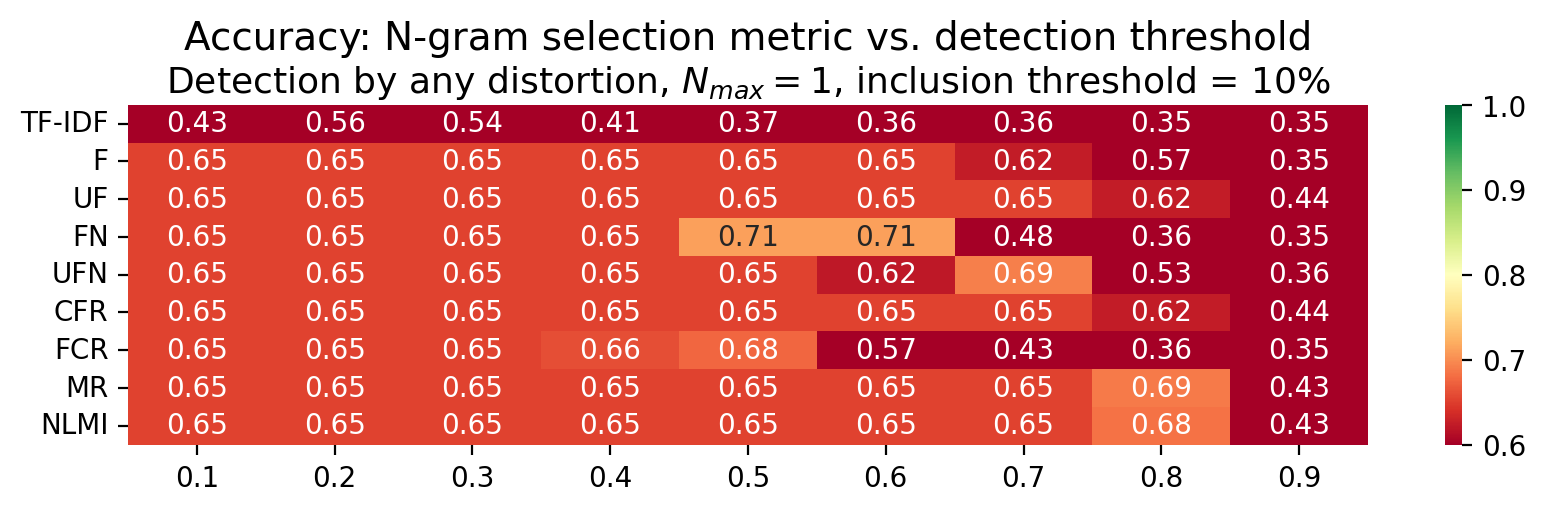

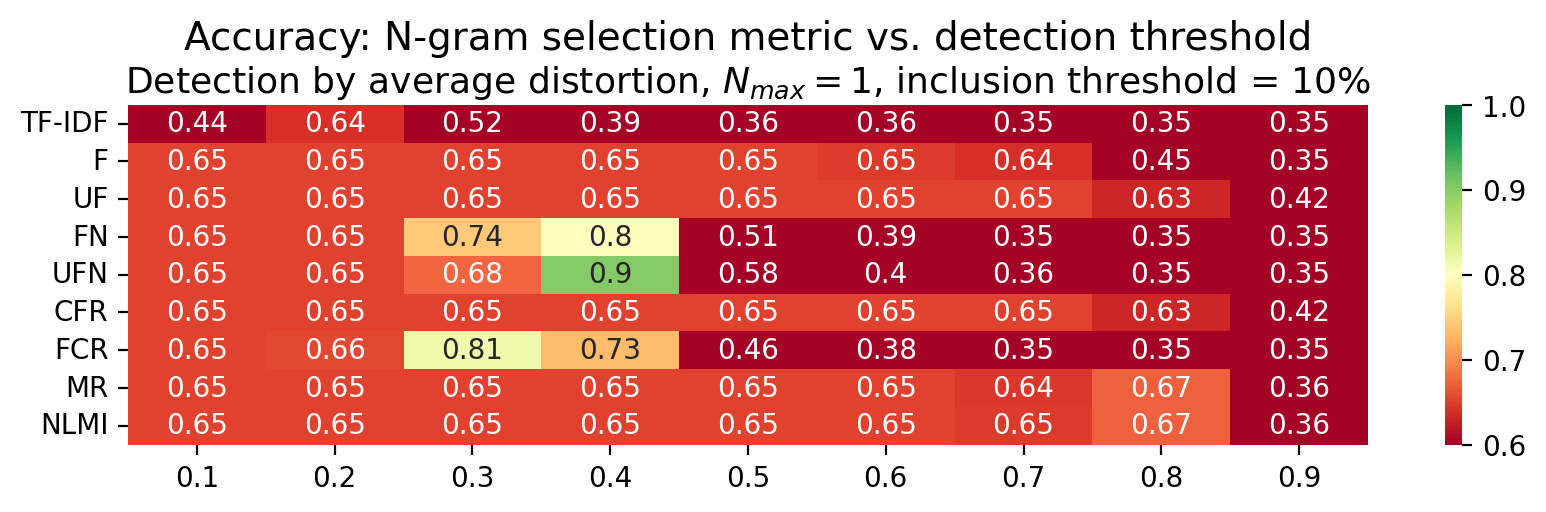

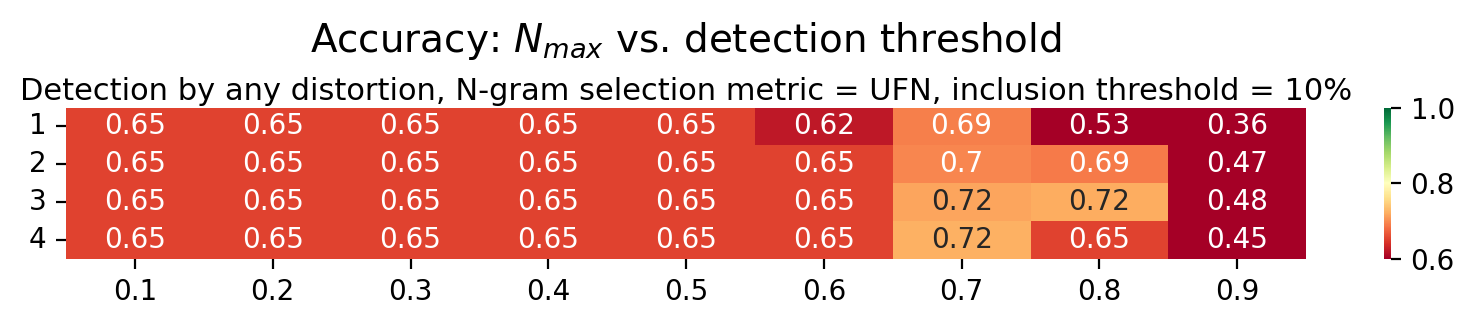

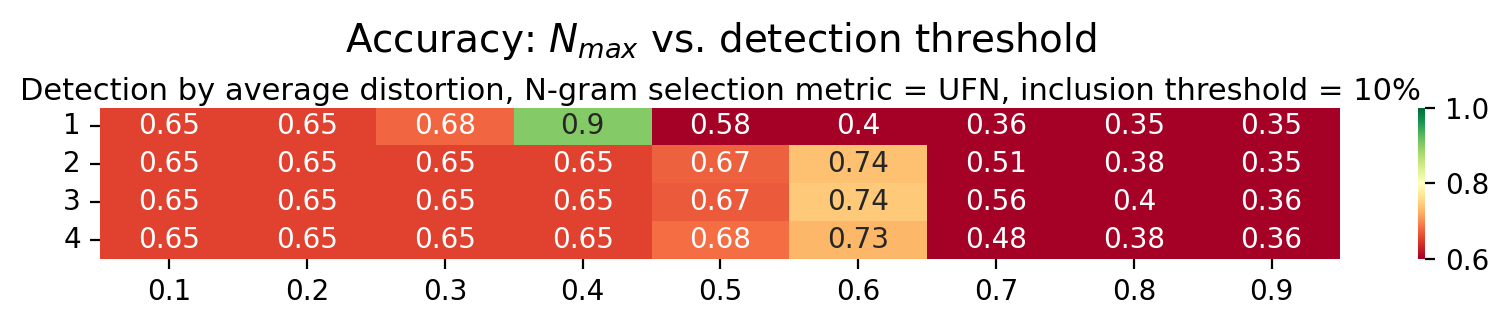

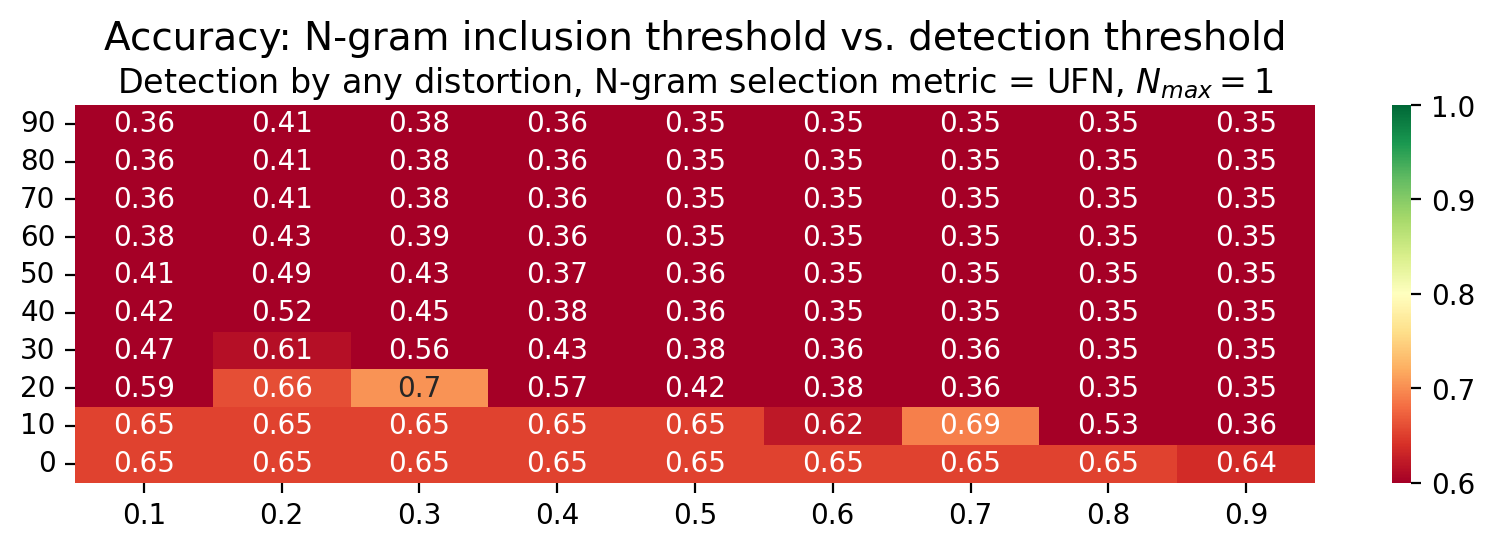

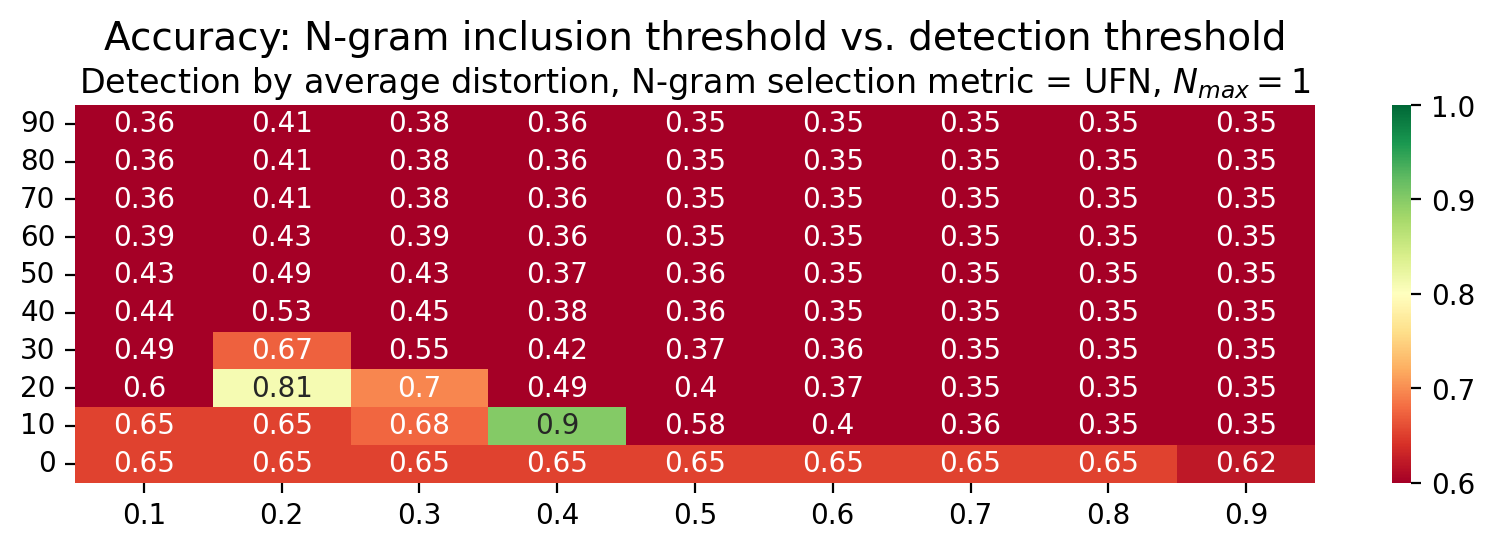

In [15]:
ngram_selection_metrics = ['TF-IDF','F','UF','FN','UFN','CFR','FCR','MR','NLMI']
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
ngram_max_values = [1, 2, 3, 4]
ngram_inclusion_thresholds = [90, 80, 70, 60, 50, 40, 30, 20, 10, 0]


# 1) N-gram selection metric - threshold
acc_analytics_threshold_any = np.zeros((len(ngram_selection_metrics), len(thresholds)))
acc_analytics_threshold_avg = np.zeros((len(ngram_selection_metrics), len(thresholds)))

for i, ngram_selection_metric in enumerate(ngram_selection_metrics):

    for k, (train_df, test_df) in enumerate(splits, start=1):
        if k == 1:
            first_split_acc_any, first_split_acc_avg = analyse_dataset(ngram_selection_metric, best_nm, best_it, train_df, test_df, 'first_split', 'plot_results')
        elif k == 2:
            second_split_acc_any, second_split_acc_avg = analyse_dataset(ngram_selection_metric, best_nm, best_it, train_df, test_df, 'second_split', 'plot_results')
        elif k == 3:
            third_split_acc_any, third_split_acc_avg = analyse_dataset(ngram_selection_metric, best_nm, best_it, train_df, test_df, 'third_split', 'plot_results')

    average_acc_data_any = {
    key: (first_split_acc_any[key] + second_split_acc_any[key] + third_split_acc_any[key]) / 3 if len (splits) == 3 else first_split_acc_any[key]
    for key in first_split_acc_any
    }

    average_acc_data_avg = {
    key: (first_split_acc_avg[key] + second_split_acc_avg[key] + third_split_acc_avg[key]) / 3  if len (splits) == 3 else first_split_acc_avg[key]
    for key in first_split_acc_avg
    }

    for j, threshold in enumerate(thresholds):
        acc_analytics_threshold_any[i, j] = average_acc_data_any[threshold]
        acc_analytics_threshold_avg[i, j] = average_acc_data_avg[threshold]

matrix_plot(
    ngram_selection_metrics, thresholds, acc_analytics_threshold_any, 1.0,
    title="Accuracy: N-gram selection metric vs. detection threshold",
    subtitle="Detection by any distortion, $N_{max}="+str(best_nm)+"$, inclusion threshold = "+str(best_it)+"%",
    vmin=1.0 - (1.0 - 0.8) * 2, vmax=1.0, titlefontsize=14, subtitlefontsize=13,
    dpi=200, width=10
)

matrix_plot(
    ngram_selection_metrics, thresholds, acc_analytics_threshold_avg, 1.0,
    title="Accuracy: N-gram selection metric vs. detection threshold",
    subtitle="Detection by average distortion, $N_{max}="+str(best_nm)+"$, inclusion threshold = "+str(best_it)+"%",
    vmin=1.0 - (1.0 - 0.8) * 2, vmax=1.0, titlefontsize=14, subtitlefontsize=13,
    dpi=200, width=10
)



# 2) ngram_max - threshold
acc_ngrammax_threshold_any = np.zeros((len(ngram_max_values), len(thresholds)))
acc_ngrammax_threshold_avg = np.zeros((len(ngram_max_values), len(thresholds)))

for i, ngram_max in enumerate(ngram_max_values):

    for k, (train_df, test_df) in enumerate(splits, start=1):
        if k == 1:
            first_split_acc_any, first_split_acc_avg = analyse_dataset(best_sm, ngram_max, best_it, train_df, test_df, 'first_split', 'plot_results')
        elif k == 2:
            second_split_acc_any, second_split_acc_avg = analyse_dataset(best_sm, ngram_max, best_it, train_df, test_df, 'second_split', 'plot_results')
        elif k == 3:
            third_split_acc_any, third_split_acc_avg = analyse_dataset(best_sm, ngram_max, best_it, train_df, test_df, 'third_split', 'plot_results')

    average_acc_data_any = {
    key: (first_split_acc_any[key] + second_split_acc_any[key] + third_split_acc_any[key]) / 3  if len (splits) == 3 else first_split_acc_any[key]
    for key in first_split_acc_any
    }

    average_acc_data_avg = {
    key: (first_split_acc_avg[key] + second_split_acc_avg[key] + third_split_acc_avg[key]) / 3  if len (splits) == 3 else first_split_acc_avg[key]
    for key in first_split_acc_avg
    }

    for j, threshold in enumerate(thresholds):
        acc_ngrammax_threshold_any[i, j] = average_acc_data_any[threshold]
        acc_ngrammax_threshold_avg[i, j] = average_acc_data_avg[threshold]

matrix_plot(
    ngram_max_values, thresholds, acc_ngrammax_threshold_any, 1.0,
    title="Accuracy: $N_{max}$ vs. detection threshold",
    subtitle="Detection by any distortion, N-gram selection metric = "+best_sm+", inclusion threshold = "+str(best_it)+"%",
    vmin=1.0 - (1.0 - 0.8) * 2, vmax=1.0, titlefontsize=14, subtitlefontsize=11,
    dpi=200, width=10
)

matrix_plot(
    ngram_max_values, thresholds, acc_ngrammax_threshold_avg, 1.0,
    title="Accuracy: $N_{max}$ vs. detection threshold",
    subtitle="Detection by average distortion, N-gram selection metric = "+best_sm+", inclusion threshold = "+str(best_it)+"%",
    vmin=1.0 - (1.0 - 0.8) * 2, vmax=1.0, titlefontsize=14, subtitlefontsize=11,
    dpi=200, width=10
)



# 3) ngram_inclusion_threshold - threshold
acc_ngram_inclusion_threshold_any = np.zeros((len(ngram_inclusion_thresholds), len(thresholds)))
acc_ngram_inclusion_threshold_avg = np.zeros((len(ngram_inclusion_thresholds), len(thresholds)))

for i, ngram_inclusion_threshold in enumerate(ngram_inclusion_thresholds):

    for k, (train_df, test_df) in enumerate(splits, start=1):
        if k == 1:
            first_split_acc_any, first_split_acc_avg = analyse_dataset(best_sm, best_nm, ngram_inclusion_threshold, train_df, test_df, 'first_split', 'plot_results')
        elif k == 2:
            second_split_acc_any, second_split_acc_avg = analyse_dataset(best_sm, best_nm, ngram_inclusion_threshold, train_df, test_df, 'second_split', 'plot_results')
        elif k == 3:
            third_split_acc_any, third_split_acc_avg = analyse_dataset(best_sm, best_nm, ngram_inclusion_threshold, train_df, test_df, 'third_split', 'plot_results')

    average_acc_data_any = {
    key: (first_split_acc_any[key] + second_split_acc_any[key] + third_split_acc_any[key]) / 3 if len (splits) == 3 else first_split_acc_any[key]
    for key in first_split_acc_any
    }

    average_acc_data_avg = {
    key: (first_split_acc_avg[key] + second_split_acc_avg[key] + third_split_acc_avg[key]) / 3 if len (splits) == 3 else first_split_acc_avg[key]
    for key in first_split_acc_avg
    }

    for j, threshold in enumerate(thresholds):
        acc_ngram_inclusion_threshold_any[i, j] = average_acc_data_any[threshold]
        acc_ngram_inclusion_threshold_avg[i, j] = average_acc_data_avg[threshold]

matrix_plot(
    ngram_inclusion_thresholds, thresholds, acc_ngram_inclusion_threshold_any, 1.0,
    title="Accuracy: N-gram inclusion threshold vs. detection threshold",
    subtitle="Detection by any distortion, N-gram selection metric = "+best_sm+", $N_{max}="+str(best_nm)+"$",
    vmin=1.0 - (1.0 - 0.8) * 2, vmax=1.0, titlefontsize=14, subtitlefontsize=12,
    dpi=200, width=10
)

matrix_plot(
    ngram_inclusion_thresholds, thresholds, acc_ngram_inclusion_threshold_avg, 1.0,
    title="Accuracy: N-gram inclusion threshold vs. detection threshold",
    subtitle="Detection by average distortion, N-gram selection metric = "+best_sm+", $N_{max}="+str(best_nm)+"$",
    vmin=1.0 - (1.0 - 0.8) * 2, vmax=1.0, titlefontsize=14, subtitlefontsize=12,
    dpi=200, width=10
)

In [16]:
grand_t1 = dt.datetime.now()
grand_delta = grand_t1 - grand_t0
str(grand_delta)

'14:10:23.119379'

### Our best model obtained through the optimal combination of hyper-parameters

In [17]:
for i, (train_df, test_df) in enumerate(splits, start=1):
    if i == 1:
        first_split_acc_any, first_split_acc_avg = analyse_dataset(best_sm, best_nm, best_it, train_df, test_df, 'first_split', 'print_results')
    elif i == 2:
        second_split_acc_any, second_split_acc_avg = analyse_dataset(best_sm, best_nm, best_it, train_df, test_df, 'second_split', 'print_results')
    elif i == 3:
        third_split_acc_any, third_split_acc_avg = analyse_dataset(best_sm, best_nm, best_it, train_df, test_df, 'third_split', 'print_results')



N-gram selection metric: UFN
N-gram max length: 1
N-gram inclusion threshold: 10
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6521739130434783 0.7894736842105263
		 0.2 0.6521739130434783 0.7894736842105263
		 0.3 0.6521739130434783 0.7894736842105263
		 0.4 0.6521739130434783 0.7894736842105263
		 0.5 0.6521739130434783 0.7894736842105263
		 0.6 0.6205533596837944 0.7623762376237624
		 0.7 0.691699604743083 0.7636363636363637
		 0.8 0.5296442687747036 0.4413145539906103
		 0.9 0.35968379446640314 0.03571428571428572

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6521739130434783 0.7894736842105263
		 0.2 0.6521739130434783 0.7894736842105263
		 0.3 0.6758893280632411 0.8009708737864077
		 0.4 0.9011857707509882 0.9221183800623053
		 0.5 0.5770750988142292 0.5201793721973094
		 0.6 0.39920948616600793 0.14606741573033705
		 0.7 0.35968379446640314 0.03571428571428572
		 0.8 0.34782608695652173 0
		 0.9 0.34782608695652173 0
